### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

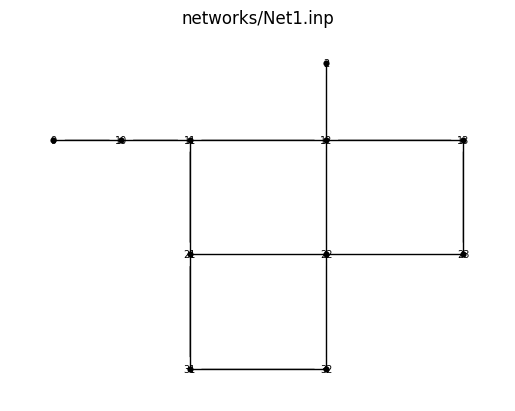

{'duration': 0.0,
 'hydraulic_timestep': 3600,
 'quality_timestep': 300,
 'rule_timestep': 360,
 'pattern_timestep': 7200,
 'pattern_start': 0.0,
 'report_timestep': 3600,
 'report_start': 0.0,
 'start_clocktime': 0.0,
 'statistic': 'NONE',
 'pattern_interpolation': False}

In [1]:
import os
from pathlib import Path
import wntr
import wntr_quantum

epanet_tmp_dir = Path("/Users/murilo/scratch_dir/vqls_solver_net1")
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = "networks/Net1.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)
wn.options.time.duration = 0

# print options
dict(wn.options.hydraulic)
dict(wn.options.time)

### Solve model using EpanetSimulator from WNTR

In [2]:
# define the classical EPANET simulator
sim = wntr.sim.EpanetSimulator(wn)

# run the EPANET simulation
results_raw_epanet = sim.run_sim()

results_raw_epanet.node["pressure"], results_raw_epanet.link["flowrate"]

(name         10         11         12         13        21         22  \
 0     89.717087  83.890205  82.317276  83.476387  82.76741  83.539085   
 
 name         23         31         32    9          2  
 0     84.931053  81.500954  77.934105  0.0  36.575996  ,
 name        10        11       12       21        22        31       110  \
 0     0.117737  0.077866  0.00816  0.01206  0.007613  0.002575 -0.048338   
 
 name       111       112       113       121       122         9  
 0     0.030407  0.011905  0.001851  0.008884  0.003734  0.117737  )

### Solve model using the classical Epanet simulator from WNTR-quantum

We now solve the same problem using the classical Epanet simulator. In this example, we use the classical `SPLU_SOLVER` from `quantum_newton_raphson` package.

In [3]:
from quantum_newton_raphson.splu_solver import SPLU_SOLVER

# define the classical EPANET simulator
linear_solver = SPLU_SOLVER()
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)

# run the EPANET simulation
results_epanet = sim.run_sim(linear_solver=linear_solver)

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

Object SPLUResult not serializable.
/Users/murilo/scratch_dir/vqls_solver_net1/sol_info.pckl not created.
Object SPLUResult not serializable.
/Users/murilo/scratch_dir/vqls_solver_net1/sol_info.pckl not created.
Object SPLUResult not serializable.
/Users/murilo/scratch_dir/vqls_solver_net1/sol_info.pckl not created.
Object SPLUResult not serializable.
/Users/murilo/scratch_dir/vqls_solver_net1/sol_info.pckl not created.
Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/vqls_solver_net1

Size of the Jacobian in EPANET simulator: 9
Size of the b vector in EPANET simulator: 9


(name         10         11        12        13        21         22  \
 0     89.717255  83.890411  82.31739  83.47654  82.76767  83.539268   
 
 name         23         31         32    9          2  
 0     84.931236  81.501236  77.934402  0.0  36.575996  ,
 name        10        11        12        21        22        31       110  \
 0     0.117737  0.077867  0.008159  0.012061  0.007613  0.002575 -0.048477   
 
 name       111       112      113       121       122         9  
 0     0.030407  0.011903  0.00185  0.008884  0.003734  0.117737  )

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [4]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=4, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=500, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

res = linear_solver(epanet_A, epanet_b)

VQLS Iteration 500 Cost 7.381e-03
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  500   F = 7.376880E-03    MAXCV = 0.000000E+00
   X = 5.435662E-02  -9.971449E-01   1.451832E+00  -1.276112E-01   1.705785E+00
      -2.935112E-02   2.390396E+00  -2.065370E+00  -2.045880E+00   1.557815E+00
       3.115673E+00   4.560999E+00   1.399606E+00  -4.063332E-01  -2.265101E+00
      -1.092011E+00  -3.411749E-01   2.915115E+00   1.526919E+00  -1.989766E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 306
         Function evaluations: 9828
         Gradient evaluations: 468


Let's check the evolution of the cost function

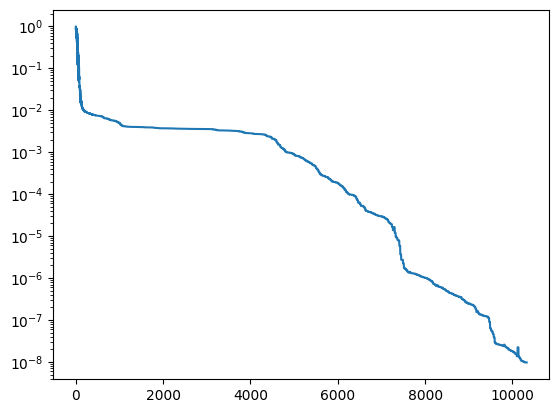

In [5]:
import matplotlib.pyplot as plt

plt.semilogy(res.logger.values)

and visualize graphically the solution

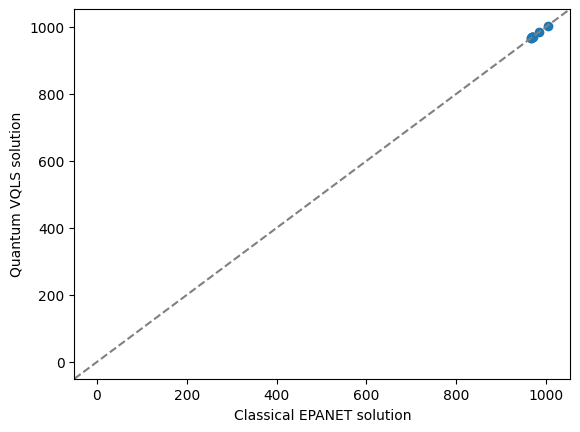

(array([1004.348,  985.231,  965.69 ,  967.393,  971.547,  969.079,  968.646,  970.07 ,  968.873]),
 array([1003.302,  984.602,  965.993,  967.067,  971.512,  969.378,  968.989,  970.072,  969.032]))

In [6]:
import numpy as np

ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution